# Copyright 2026 Cognite AS

## Import the Libraries and Modules

In [1]:
import sys
from pathlib import Path

utils = str(Path("../utils").resolve())
if utils not in sys.path:
    sys.path.append(utils)

from cognite_auth import interactive_client

## Create the Cognite Client

In [2]:
client = interactive_client()

In [4]:
from datetime import datetime, UTC

from cognite.client.data_classes.data_modeling.cdm.v1 import (
    CogniteTimeSeries,
    CogniteActivity,
    CogniteAsset,
)
from cognite.client.data_classes.data_modeling import (
    DirectRelationReference,
    NodeId,
    ViewId,
)
from cognite.client.data_classes import filters

### List data

Running the first command might open a new tab to verify the log in, if so, you can close that tab and come back to the notebook.

Below, we will look at how you can list different types of data from CDF. Note that when we list instances, we list all types of data from CDF, the `instance_type` tells us if it is a node or an edge. Unless we provide a source to retrieve properties from, the returned data is just the basic properties like space, external ID and timestamps corresponding to when the instance was created and last updated.

**Good to know**: You can use `list` when you want to run basic queries. Later, we'll take a look at the much more powerful `query` endpoint.

In [5]:
client.data_modeling.instances.list(space="world_data", limit=10)

,space,external_id,version,last_updated_time,created_time,instance_type
0,world_data,region:Africa,9,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node
1,world_data,region:Americas,10,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node
2,world_data,region:Asia,10,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node
3,world_data,region:Europe,10,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node
4,world_data,region:Oceania,8,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node
5,world_data,CAN,10,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node
6,world_data,CCK,7,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node
7,world_data,PRK,10,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node
8,world_data,COL,10,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node
9,world_data,ZMB,9,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node


If we want to filter for specific `instance_type`: 
(here looking at edges, we can see the `start_node` and `end_note`)

In [6]:
client.data_modeling.instances.list(space="world_data", instance_type='edge', limit=5)

,space,external_id,version,last_updated_time,created_time,instance_type,type,start_node,end_node
0,world_data,LH67HoHcjgG0mynKwMAnW90Jzur6IEFR87nAVf3AhNM=,1,2026-02-06 12:34:33.386,2026-02-06 12:34:33.386,edge,"{'space': 'cdf_cdm', 'external_id': 'has-parent'}","{'space': 'world_data', 'external_id': 'CAN'}","{'space': 'world_data', 'external_id': 'region..."
1,world_data,-EX-brCFeAhjgOgy28QMG1fZkgQnStsKMlLhZZCt3sk=,1,2026-02-06 12:34:33.386,2026-02-06 12:34:33.386,edge,"{'space': 'cdf_cdm', 'external_id': 'has-parent'}","{'space': 'world_data', 'external_id': 'CCK'}","{'space': 'world_data', 'external_id': 'region..."
2,world_data,AeKi03ctSCGn7Xv0k-XQvUm1Y5JxFuYJwEOMNZH79vI=,1,2026-02-06 12:34:33.386,2026-02-06 12:34:33.386,edge,"{'space': 'cdf_cdm', 'external_id': 'has-parent'}","{'space': 'world_data', 'external_id': 'PRK'}","{'space': 'world_data', 'external_id': 'region..."
3,world_data,3co_Jd6AFhEZ3qgW0174rx8xpIJ0HlDH4CowsqrES4o=,1,2026-02-06 12:34:33.386,2026-02-06 12:34:33.386,edge,"{'space': 'cdf_cdm', 'external_id': 'has-parent'}","{'space': 'world_data', 'external_id': 'COL'}","{'space': 'world_data', 'external_id': 'region..."
4,world_data,N5j2tVhNz6AxgtugdQv4LzLTaa1qDoTJ_FuFVdQxvbQ=,1,2026-02-06 12:34:33.386,2026-02-06 12:34:33.386,edge,"{'space': 'cdf_cdm', 'external_id': 'has-parent'}","{'space': 'world_data', 'external_id': 'ZMB'}","{'space': 'world_data', 'external_id': 'region..."


#### List CogniteTimeSeries instances from the core data model

In [7]:
tss = client.data_modeling.instances.list(
    sources=CogniteTimeSeries.get_source(),
    limit=5,  # or None for all
)

# Convert to pandas DataFrame
df = tss.to_pandas()
df

,space,external_id,version,last_updated_time,created_time,instance_type,name,description,type,assets,isStep,equipment
0,world_data,CAN,10,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node,Canada,Country: Canada,numeric,"[{'space': 'world_data', 'externalId': 'CAN'}]",False,[]
1,world_data,PRK,10,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node,"Korea, Dem. People's Rep.",Country: Korea (Democratic People's Republic of),numeric,"[{'space': 'world_data', 'externalId': 'PRK'}]",False,[]
2,world_data,COL,10,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node,Colombia,Country: Colombia,numeric,"[{'space': 'world_data', 'externalId': 'COL'}]",False,[]
3,world_data,ZMB,9,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node,Zambia,Country: Zambia,numeric,"[{'space': 'world_data', 'externalId': 'ZMB'}]",False,[]
4,world_data,TGO,9,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node,Togo,Country: Togo,numeric,"[{'space': 'world_data', 'externalId': 'TGO'}]",False,[]


#### Listing CogniteActivities

In [8]:
client.data_modeling.instances.list(sources=CogniteActivity.get_source(), limit=5)

,space,external_id,version,last_updated_time,created_time,instance_type,assets,equipment,timeSeries,name,description,endTime,startTime,sourceId,sourceContext
0,world_data,2021-0134-GRC,1,2026-02-09 10:00:30.763,2026-02-09 10:00:30.763,node,"[{'space': 'world_data', 'externalId': 'GRC'}]",[],[],Earthquake,Group: Natural | Subgroup: Geophysical | Type:...,2021-03-03T00:00:00+00:00,2021-03-03T00:00:00+00:00,2021-0134-GRC,EM-DAT
1,world_data,2017-0015-ITA,1,2026-02-09 10:00:30.763,2026-02-09 10:00:30.763,node,"[{'space': 'world_data', 'externalId': 'ITA'}]",[],[],Earthquake,Group: Natural | Subgroup: Geophysical | Type:...,2017-01-19T00:00:00+00:00,2017-01-18T00:00:00+00:00,2017-0015-ITA,EM-DAT
2,world_data,2017-0350-CHE,1,2026-02-09 10:00:30.819,2026-02-09 10:00:30.819,node,"[{'space': 'world_data', 'externalId': 'CHE'}]",[],[],Mass movement (dry),Group: Natural | Subgroup: Geophysical | Type:...,2017-08-23T00:00:00+00:00,2017-08-23T00:00:00+00:00,2017-0350-CHE,EM-DAT
3,world_data,2017-0280-GRC,1,2026-02-09 10:00:30.819,2026-02-09 10:00:30.819,node,"[{'space': 'world_data', 'externalId': 'GRC'}]",[],[],Earthquake,Group: Natural | Subgroup: Geophysical | Type:...,2017-07-21T00:00:00+00:00,2017-07-21T00:00:00+00:00,2017-0280-GRC,EM-DAT
4,world_data,2014-0174-GRC,1,2026-02-09 10:00:30.807,2026-02-09 10:00:30.807,node,"[{'space': 'world_data', 'externalId': 'GRC'}]",[],[],Earthquake,Group: Natural | Subgroup: Geophysical | Type:...,2014-05-24T00:00:00+00:00,2014-05-24T00:00:00+00:00,2014-0174-GRC,EM-DAT


## Searching in CDF

- Search the CDF resource types
- Filter the search results

### Exact search on one field (e.g. name, description etc)

In [9]:
# In this exercise, we will search using the Cognite Asset view:
asset_view_id = CogniteAsset.get_source()

In [10]:
res = client.data_modeling.instances.search(
    view=asset_view_id,
    query="islands",
    properties=["name"],
)
res.to_pandas()["name"]

0                                    Åland Islands
1                                     Cook Islands
2                                    Faroe Islands
3                                 Marshall Islands
4                                  Solomon Islands
5                                   Cayman Islands
6                          Cocos (Keeling) Islands
7                         Northern Mariana Islands
8                      Falkland Islands (Malvinas)
9                            Virgin Islands (U.S.)
10                          British Virgin Islands
11                        Turks and Caicos Islands
12               Heard Island and McDonald Islands
13            United States Minor Outlying Islands
14    South Georgia and the South Sandwich Islands
Name: name, dtype: str

### Search using multiple terms with at least one matching

By default, the search operator AND is used when multiple search terms are provided. Thus, we pass OR in the query below:

In [11]:
res = client.data_modeling.instances.search(
    view=asset_view_id,
    query="Canada Norway Australia",
    properties=["name"],
    operator="OR",
)
res

,space,external_id,version,last_updated_time,created_time,instance_type,path,root,parent,pathLastUpdatedTime,name,description
0,world_data,CAN,10,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node,"[{'space': 'world_data', 'externalId': 'global...","{'space': 'world_data', 'externalId': 'global'}","{'space': 'world_data', 'externalId': 'region:...",2026-02-11T11:03:55.135662+00:00,Canada,Country: Canada
1,world_data,NOR,10,2026-02-11 11:03:55.135,2026-02-06 12:34:34.692,node,"[{'space': 'world_data', 'externalId': 'global...","{'space': 'world_data', 'externalId': 'global'}","{'space': 'world_data', 'externalId': 'region:...",2026-02-11T11:03:55.135662+00:00,Norway,Country: Norway
2,world_data,AUS,8,2026-02-11 11:03:55.135,2026-02-06 12:34:34.630,node,"[{'space': 'world_data', 'externalId': 'global...","{'space': 'world_data', 'externalId': 'global'}","{'space': 'world_data', 'externalId': 'region:...",2026-02-11T11:03:55.135662+00:00,Australia,Country: Australia


#### Get all time series for the above asset

In [13]:
time_series_view_id = CogniteTimeSeries.get_source()

res = client.data_modeling.instances.search(
    view=time_series_view_id,
    filter=filters.ContainsAny(
        # We use the time series view to reference the 'assets' property, which is a list of
        # direct relations to connected assets
        property=time_series_view_id.as_property_ref("assets"),
        values=[DirectRelationReference("world_data", "CAN")],
    )
)

res

,space,external_id,version,last_updated_time,created_time,instance_type,name,description,type,assets,isStep,equipment
0,world_data,CAN,10,2026-02-11 11:03:55.135,2026-02-06 12:34:33.386,node,Canada,Country: Canada,numeric,"[{'space': 'world_data', 'externalId': 'CAN'}]",False,[]


## Retrieve data from CDF

### Retrieve datapoints from time series

In [14]:
dps_list = client.time_series.data.retrieve(
    instance_id=[
        NodeId("world_data", "NRU"),
        NodeId("world_data", "ESP"),
    ],
    start=datetime(2000, 1, 1, tzinfo=UTC),
    end=datetime(2024, 1, 2, tzinfo=UTC),
    limit=10,
)

dps_list

identifier,"NodeId(space='world_data', external_id='NRU')","NodeId(space='world_data', external_id='ESP')"
2000-12-31 23:00:00,10677.0,39889852.0
2001-12-31 23:00:00,10643.0,40057389.0
2002-12-31 23:00:00,10567.0,40223509.0
2003-12-31 23:00:00,10449.0,40386875.0
2004-12-31 23:00:00,10335.0,40567864.0
2005-12-31 23:00:00,10219.0,40850412.0
2006-12-31 23:00:00,10102.0,41431558.0
2007-12-31 23:00:00,9990.0,42187645.0
2008-12-31 23:00:00,9906.0,42921895.0
2009-12-31 23:00:00,9848.0,43653155.0


#### Retrieve all items related to an asset

In [15]:
# We have a node representing Europe:
europe = client.data_modeling.instances.retrieve_nodes(
    NodeId("world_data", "region:Europe"),
    node_cls=CogniteAsset,
)
# Let's check out what the parent of Europe is:
europe.parent

DirectRelationReference(space='world_data', external_id='global')

#### Let's now fetch the children of this asset (i.e. countries in Europe)

In [16]:
countries = client.data_modeling.instances.list(
    sources=asset_view_id,
    filter=filters.Equals(
        property=asset_view_id.as_property_ref("parent"),
        value=europe.as_id(),
    ),
    limit=None,
)
len(countries)

51

#### Retrieve events ('activities')

In [17]:
activity_view = CogniteActivity.get_source()

events = client.data_modeling.instances.search(
    view=activity_view,
    filter=filters.ContainsAny(
        property=activity_view.as_property_ref("assets"),
        values=[DirectRelationReference("world_data", "ITA")],
    ),
    limit=5,
)
events

,space,external_id,version,last_updated_time,created_time,instance_type,assets,equipment,timeSeries,name,description,endTime,startTime,sourceId,sourceContext
0,world_data,2017-0015-ITA,1,2026-02-09 10:00:30.763,2026-02-09 10:00:30.763,node,"[{'space': 'world_data', 'externalId': 'ITA'}]",[],[],Earthquake,Group: Natural | Subgroup: Geophysical | Type:...,2017-01-19T00:00:00+00:00,2017-01-18T00:00:00+00:00,2017-0015-ITA,EM-DAT
1,world_data,2016-0313-ITA,1,2026-02-09 10:00:31.657,2026-02-09 10:00:31.657,node,"[{'space': 'world_data', 'externalId': 'ITA'}]",[],[],Earthquake,Group: Natural | Subgroup: Geophysical | Type:...,2016-08-24T00:00:00+00:00,2016-08-24T00:00:00+00:00,2016-0313-ITA,EM-DAT
2,world_data,2016-0357-ITA,1,2026-02-09 10:00:31.919,2026-02-09 10:00:31.919,node,"[{'space': 'world_data', 'externalId': 'ITA'}]",[],[],Earthquake,Group: Natural | Subgroup: Geophysical | Type:...,2016-10-26T00:00:00+00:00,2016-10-26T00:00:00+00:00,2016-0357-ITA,EM-DAT
3,world_data,2017-0349-ITA,1,2026-02-09 10:00:32.277,2026-02-09 10:00:32.277,node,"[{'space': 'world_data', 'externalId': 'ITA'}]",[],[],Earthquake,Group: Natural | Subgroup: Geophysical | Type:...,2017-08-23T00:00:00+00:00,2017-08-23T00:00:00+00:00,2017-0349-ITA,EM-DAT
4,world_data,2016-0358-ITA,1,2026-02-09 10:00:32.355,2026-02-09 10:00:32.355,node,"[{'space': 'world_data', 'externalId': 'ITA'}]",[],[],Earthquake,Group: Natural | Subgroup: Geophysical | Type:...,2016-10-30T00:00:00+00:00,2016-10-30T00:00:00+00:00,2016-0358-ITA,EM-DAT


#### Retrieve datapoints after 2020 for three countries

In [18]:
italia_id = NodeId("world_data", "ITA")
norway_id = NodeId("world_data", "NOR")
france_id = NodeId("world_data", "FRA")

df = client.time_series.data.retrieve_dataframe(
    instance_id=[italia_id, norway_id, france_id],
    start=datetime(2020, 1, 1, tzinfo=UTC)
)
df

identifier,"NodeId(space='world_data', external_id='ITA')","NodeId(space='world_data', external_id='NOR')","NodeId(space='world_data', external_id='FRA')"
2020-12-31 23:00:00,60627498.0,5234519.0,66724104.0
2021-12-31 23:00:00,60536709.0,5276968.0,66918020.0
2022-12-31 23:00:00,60421760.0,5311916.0,67101930.0
2023-12-31 23:00:00,59729081.0,5347896.0,67248926.0
2024-12-31 23:00:00,59449527.0,5379475.0,67379908.0
2025-12-31 23:00:00,59066225.0,5408320.0,67499343.0


In [19]:
# To extract the data for France, you can pass a NodeId:
df[france_id]

identifier,"NodeId(space='world_data', external_id='FRA')"
2020-12-31 23:00:00,66724104.0
2021-12-31 23:00:00,66918020.0
2022-12-31 23:00:00,67101930.0
2023-12-31 23:00:00,67248926.0
2024-12-31 23:00:00,67379908.0
2025-12-31 23:00:00,67499343.0


### Retrieve aggregated data using a granularity of 10 years

In [20]:
df = client.time_series.data.retrieve_dataframe(
    instance_id=italia_id,
    aggregates=["average", "max", "min"],
    granularity="10y",
)
df

identifier NodeId(space='world_data', external_id='ITA')              \
aggregate                                        average         max   
1970-01-01                                  5.397682e+07  55441001.0   
1980-01-01                                  5.635606e+07  56593071.0   
1990-01-01                                  5.673035e+07  56844303.0   
2000-01-01                                  5.712251e+07  57969484.0   
2010-01-01                                  5.944613e+07  60789140.0   
2020-01-01                                  5.999656e+07  60627498.0   

identifier              
aggregate          min  
1970-01-01  52519000.0  
1980-01-01  55718260.0  
1990-01-01  56596155.0  
2000-01-01  56860281.0  
2010-01-01  58143979.0  
2020-01-01  59066225.0

In [21]:
# To extract the "max" aggregate, you can do the following:
df[italia_id, "max"]

1970-01-01    55441001.0
1980-01-01    56593071.0
1990-01-01    56844303.0
2000-01-01    57969484.0
2010-01-01    60789140.0
2020-01-01    60627498.0
Name: (NodeId(space='world_data', external_id='ITA'), max), dtype: float64

### Retrieve latest datapoint before a particular time (last or any past time point)

In [22]:
latest_dp = client.time_series.data.retrieve_latest(
    instance_id=norway_id,
    before="5w-ago",  # when not given, uses 'now'
)
latest_dp

identifier,"NodeId(space='world_data', external_id='NOR')"
2025-12-31 23:00:00,5408320.0


### Plot datapoints
#### **Note**: Requires matplotlib to be installed

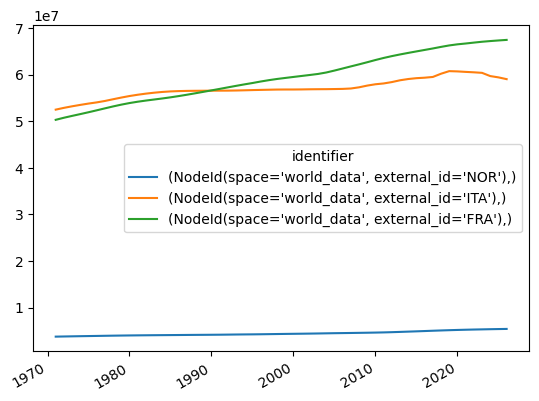

In [23]:
client.time_series.data.retrieve(
    instance_id=[norway_id, italia_id, france_id]
).to_pandas().plot();